**Imports**

In [319]:
from collections import Counter
from sklearn.model_selection import train_test_split as tts
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')


from yellowbrick.classifier import ClassificationReport

import numpy as np 
import pandas as pd

In [320]:
data_url = 'https://raw.githubusercontent.com/georgetown-analytics/Formula1/main/data/processed/final_features.csv'
data_df = pd.read_csv(data_url, sep = ',', engine = 'python', encoding = 'latin-1')

**Model Evaluation**

In [321]:
data_df.head()

,raceId,driverId,CompletionStatus,alt,grid,trackType,average_lap_time,minimum_lap_time,year,PRCP,...,oneHot_circuits_1,oneHot_circuits_2,oneHot_circuits_3,oneHot_circuits_4,oneHot_circuits_5,oneHot_circuits_6,alt_trans,PRCP_trans,normalized_minLapTime,normalized_avgLapTime
0,1,2,1,10,9,1,97635.672414,88283,2009,0.0,...,0,1,0,0,0,0,2.890372,0.0,0.994132,0.002958
1,1,3,1,10,5,1,97612.172414,87706,2009,0.0,...,0,1,0,0,0,0,2.890372,0.0,0.987635,0.002717
2,1,4,1,10,10,1,97597.637931,88712,2009,0.0,...,0,1,0,0,0,0,2.890372,0.0,0.998963,0.002568
3,1,6,0,10,11,1,91822.235294,89923,2009,0.0,...,0,1,0,0,0,0,2.890372,0.0,1.012600,-0.058430
4,1,7,1,10,17,1,97622.103448,89823,2009,0.0,...,0,1,0,0,0,0,2.890372,0.0,1.011474,0.002819


In [322]:
data_df.shape

(9258, 22)

In [323]:
data_df.isna().sum()

raceId                   0
driverId                 0
CompletionStatus         0
alt                      0
grid                     0
trackType                0
average_lap_time         0
minimum_lap_time         0
year                     0
PRCP                     0
TAVG                     0
isHistoric               0
oneHot_circuits_1        0
oneHot_circuits_2        0
oneHot_circuits_3        0
oneHot_circuits_4        0
oneHot_circuits_5        0
oneHot_circuits_6        0
alt_trans                0
PRCP_trans               0
normalized_minLapTime    0
normalized_avgLapTime    0
dtype: int64

In [324]:
#Set features and target. 

X = data_df.loc[:,['trackType', 'alt_trans', 'grid', 'normalized_minLapTime', 'normalized_avgLapTime', 'year', 'PRCP_trans', 
'TAVG', 'isHistoric', "oneHot_circuits_1", "oneHot_circuits_2", "oneHot_circuits_3",
"oneHot_circuits_4","oneHot_circuits_5","oneHot_circuits_6"]]

y = data_df["CompletionStatus"]

In [325]:
#Test our data on various estimators.

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state = 3)

def score_model(X_train, y_train, X_test, y_test, estimator, **kwargs):
   
    estimator.fit(X_train, y_train, **kwargs)  
    
    expected  = y_test
    predicted = estimator.predict(X_test)
    
    # Compute and return F1
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))
    

# Instantiate the classification models
models = [
    SVC(gamma='auto'), 
    LinearSVC(),  
    KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), 
    LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_train, y_train, X_test, y_test, model)

SVC: 0.8678304239401496
LinearSVC: 0.8724505327245053
KNeighborsClassifier: 0.8467058056099152
LogisticRegression: 0.8724505327245053
LogisticRegressionCV: 0.8724505327245053
BaggingClassifier: 0.8774730996181881
ExtraTreesClassifier: 0.8880721683929167
RandomForestClassifier: 0.8996307485733467


In [326]:
#In this step of our evaluation process, each time our models have performed abnormally well.
#We suspect that their may be data leakage taking place due to class imbalance.

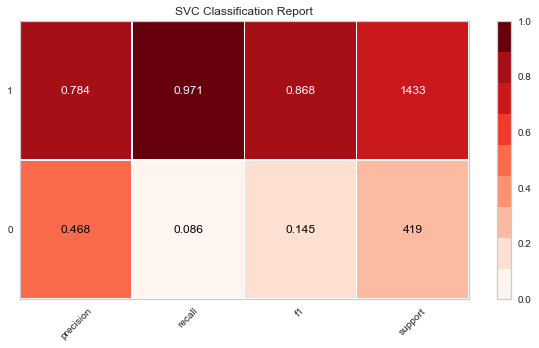

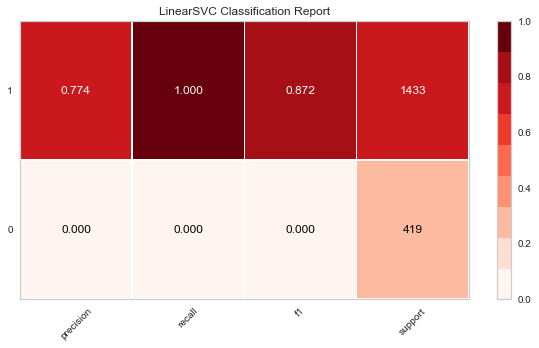

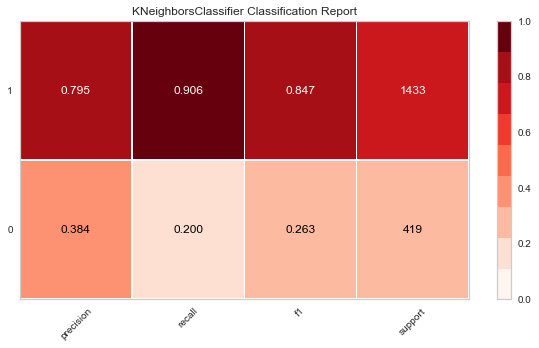

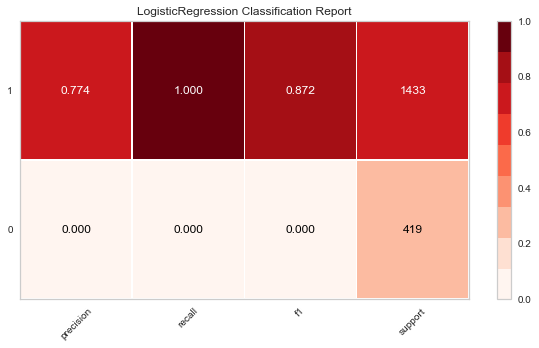

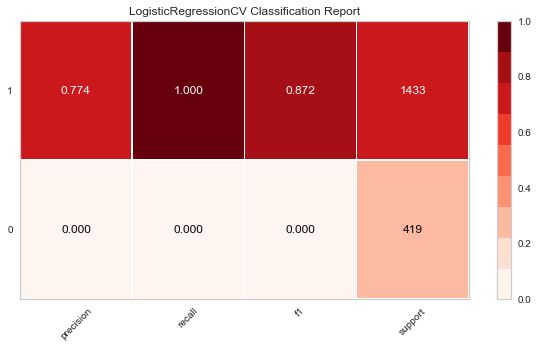

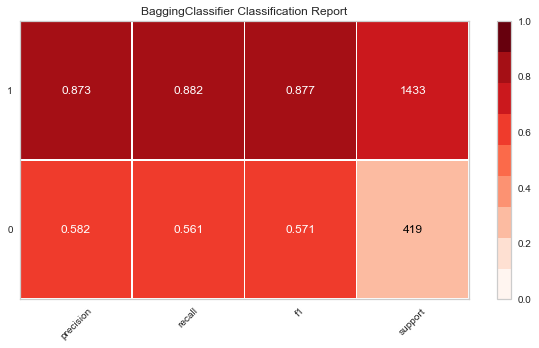

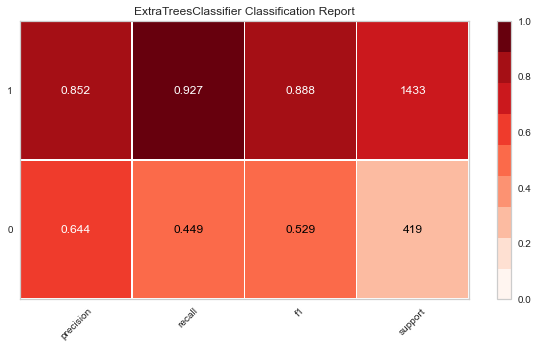

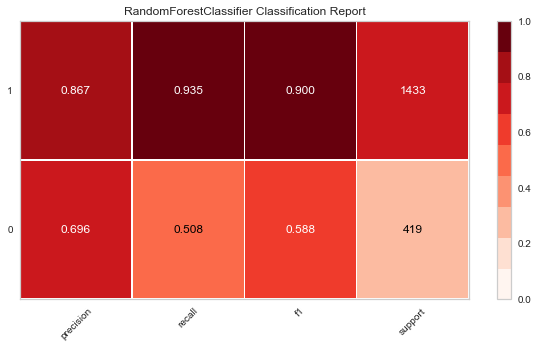

In [327]:
#Visualizing our models to try to detect class imbalance. 

def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        estimator, 
        classes=[0,1], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state = 3)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X, y, model)

In [328]:
data_df.CompletionStatus.value_counts()

1    7108
0    2150
Name: CompletionStatus, dtype: int64

In [329]:
#These results warrant potential data leakage due to class imbalance.

In [330]:
#We will address this issue using the SMOTE preprocessing algorithm.

In [331]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 5675), (1, 5675)]


In [332]:
#Evaluate models on our resampled data.

In [333]:
def score_model(X_resampled, y_resampled, X_test, y_test, estimator, **kwargs):
   
    # Instantiate the classification model and visualizer
    estimator.fit(X_resampled, y_resampled, **kwargs)  
    
    expected  = y_test
    predicted = estimator.predict(X_test)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))
    

models = [
    SVC(gamma='auto'), 
    NuSVC(gamma='auto'), 
    LinearSVC(),  
    KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), 
    LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_resampled, y_resampled, X_test, y_test, model)

SVC: 0.765210899589399
NuSVC: 0.7790697674418604
LinearSVC: 0.0
KNeighborsClassifier: 0.7299610894941634
LogisticRegression: 0.8250166333998669
LogisticRegressionCV: 0.8342632097144733
BaggingClassifier: 0.8448212311094729
ExtraTreesClassifier: 0.8811813186813187
RandomForestClassifier: 0.8881094352858645


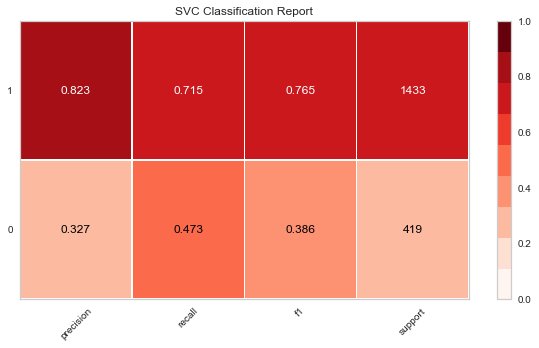

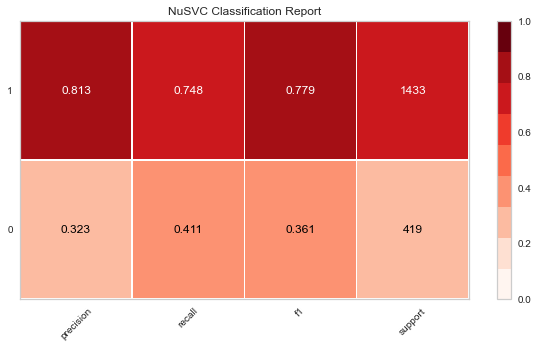

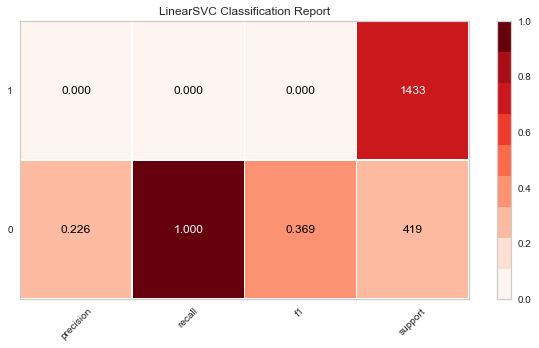

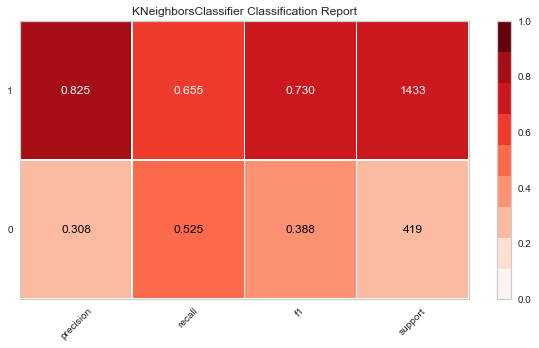

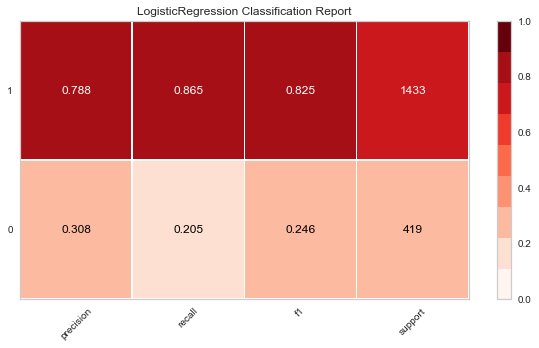

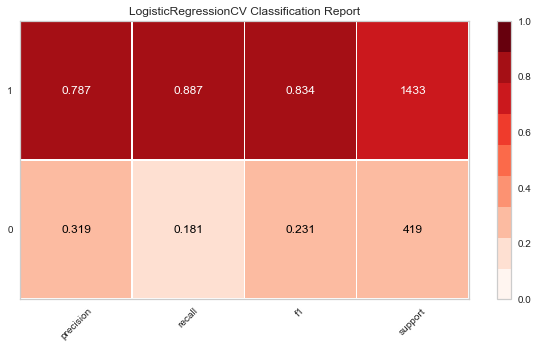

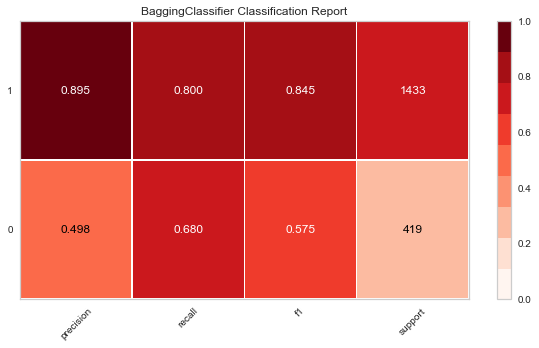

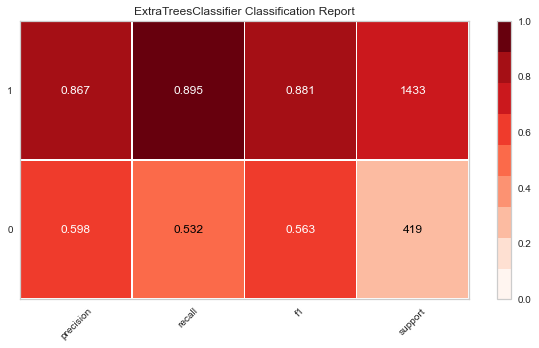

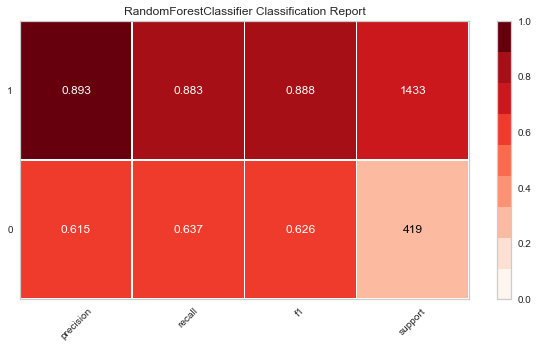

In [334]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        estimator, 
        classes=[0,1], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    visualizer.fit(X_resampled, y_resampled)
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X, y, model)

In [335]:
#These results are technically worse performing but we can assume that these models capture 
#the entirety of our data.

Our most viable models seem to be:
- LogisticRegressionCV
- BaggingClassifier
- ExtraTreesClassifier
- RandomForestClassifier

**Model Evaluation Part II: Plotting our Most Viable Models**

In [336]:
#Plotting the ROC Curves of our Most Viable Models

In [337]:
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
bc = BaggingClassifier()
bc.fit(X_resampled, y_resampled)

BaggingClassifier()

In [338]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=100)
etc.fit(X_resampled, y_resampled)

ExtraTreesClassifier()

In [339]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [340]:
from sklearn.linear_model import LogisticRegressionCV
logregcv = LogisticRegressionCV(cv=3)
logregcv.fit(X_resampled, y_resampled)

LogisticRegressionCV(cv=3)

In [341]:
from sklearn.metrics import plot_roc_curve

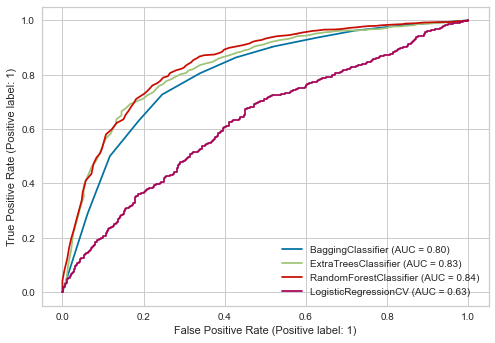

In [342]:
disp = plot_roc_curve(bc, X_test, y_test)
plot_roc_curve(etc, X_test, y_test, ax=disp.ax_);
plot_roc_curve(rfc, X_test, y_test, ax=disp.ax_);
plot_roc_curve(logregcv, X_test, y_test, ax=disp.ax_)

In [343]:
#Bagging Classifier, Extra Trees Classifier, and Random Forest Classifier hug the upper left corner of the plot.
#These models also have high AUC scores, suggesting that they can distinguish our target classes well. 

In [344]:
#Plotting the Confusion Matrices of our Models

In [345]:
from sklearn.metrics import plot_confusion_matrix

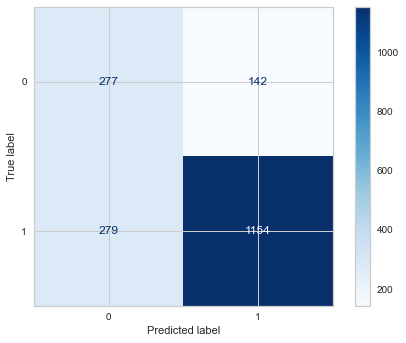

In [346]:
#Bagging Classifier
disp = plot_confusion_matrix(bc, X_test, y_test, cmap='Blues', values_format='d')

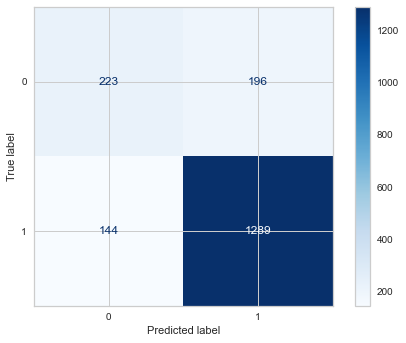

In [347]:
#Extra Trees Classifier
disp = plot_confusion_matrix(etc, X_test, y_test, cmap='Blues', values_format='d')

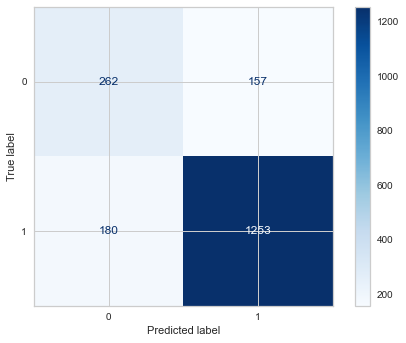

In [348]:
#Random Forest Classifier
disp = plot_confusion_matrix(rfc, X_test, y_test, cmap='Blues', values_format='d')

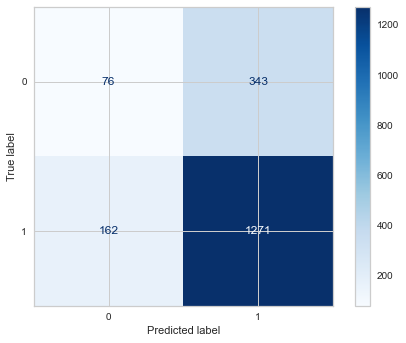

In [349]:
#Logistic Regression CV
disp = plot_confusion_matrix(logregcv, X_test, y_test, cmap='Blues', values_format='d')

**Model Evaluation Part III: Selecting the Most Specific Model**

- Bagging Classifier

In [350]:
from sklearn import metrics

y_pred_class = bc.predict(X_test)

In [351]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [352]:
#Classification Accuracy: Overall, how often is the classifier correct?

print((TP + TN) / (TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.7726781857451404
0.7726781857451404


In [353]:
#Classification Error: Overall, how often is the classifier incorrect?

print((FP + FN) / (TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.22732181425485962
0.22732181425485964


In [354]:
#Sensitivity: When the actual value is positive, how often is the prediction correct?

print(TP / (TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.8053035589672016
0.8053035589672016


In [355]:
#Specificity: When the actual value is negative, how often is the prediction correct?
#When we predict crash/DNF, how often are we correct?


print(TN / (TN + FP))

0.6610978520286396


In [356]:
#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

print(FP / (TN + FP))

0.33890214797136037


In [357]:
#Precision: When a positive value is predicted, how often is the prediction correct?

print(TP / (TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.8904320987654321
0.8904320987654321


- Extra Trees Classifier

In [358]:
y_pred_class = etc.predict(X_test)

In [359]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [360]:
#Classification Accuracy: Overall, how often is the classifier correct?

print((TP + TN) / (TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.816414686825054
0.816414686825054


In [361]:
#Classification Error: Overall, how often is the classifier incorrect?

print((FP + FN) / (TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.183585313174946
0.18358531317494597


In [362]:
#Sensitivity: When the actual value is positive, how often is the prediction correct?

print(TP / (TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.8995115143056525
0.8995115143056525


In [363]:
#Specificity: When the actual value is negative, how often is the prediction correct?
#When we predict crash/DNF, how often are we correct?


print(TN / (TN + FP))

0.5322195704057279


In [364]:
#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

print(FP / (TN + FP))

0.4677804295942721


In [365]:
#Precision: When a positive value is predicted, how often is the prediction correct?

print(TP / (TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.868013468013468
0.868013468013468


- Random Forest Classifier

In [366]:
y_pred_class = rfc.predict(X_test)

In [367]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [368]:
#Classification Accuracy: Overall, how often is the classifier correct?

print((TP + TN) / (TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.8180345572354212
0.8180345572354212


In [369]:
#Classification Error: Overall, how often is the classifier incorrect?

print((FP + FN) / (TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.18196544276457882
0.18196544276457882


In [370]:
#Sensitivity: When the actual value is positive, how often is the prediction correct?

print(TP / (TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.8743893928820656
0.8743893928820656


In [371]:
#Specificity: When the actual value is negative, how often is the prediction correct?
#When we predict crash/DNF, how often are we correct?


print(TN / (TN + FP))

0.6252983293556086


In [372]:
#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

print(FP / (TN + FP))

0.3747016706443914


In [373]:
#Precision: When a positive value is predicted, how often is the prediction correct?

print(TP / (TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.8886524822695036
0.8886524822695036


- Logistic Regression CV

In [374]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [375]:
#Classification Accuracy: Overall, how often is the classifier correct?

print((TP + TN) / (TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.8180345572354212
0.8180345572354212


In [376]:
#Classification Error: Overall, how often is the classifier incorrect?

print((FP + FN) / (TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.18196544276457882
0.18196544276457882


In [377]:
#Sensitivity: When the actual value is positive, how often is the prediction correct?

print(TP / (TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.8743893928820656
0.8743893928820656


In [378]:
#Specificity: When the actual value is negative, how often is the prediction correct?
#When we predict crash/DNF, how often are we correct?


print(TN / (TN + FP))

0.6252983293556086


In [379]:
#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

print(FP / (TN + FP))

0.3747016706443914


In [380]:
#Precision: When a positive value is predicted, how often is the prediction correct?

print(TP / (TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.8886524822695036
0.8886524822695036


**Findings**

- After multiple rounds of data preprocessing and training using the SMOTE algorithm, we discovered that the most viable model for predicting vehicle failure in a given Formula 1 race is a Bagging Classifier Model. 
- This model produced a Specificity rate of about 66%.
- We conclude that this Bagging Classifier Model correctly predicts a vehicle failure about 66% of the time.

**Future Implications**

Future Implications of these results suggest a few things:
- For increased model specificity performance we can increase the threshold for predicting vehicle failure (0) while sacrificing the performance of accurately predicting finishes (1). 
- Producing a more specific model at the risk of sacrificing sensitivity is a risk that is well worth it when considering the business-case of our project. 
- With driver safety and potential financial risk in mind, we would rather produce a model more prone to predicting that a driver would crash, when in reality they might have actually finished. 
- We prefer this type of error to the alternative, which is producing a model more prone to predicting that a driver would finish, when in reality they actually crash/do not finish.
- Another future implication of these results would be to construct a robust data preprocessing pipeline that includes every transformation that we have performed on our data prior to modeling. 
- This would be especially useful to standardize unprocessed, out-of-sample data in an efficient way to be prepared for modeling. 
- Lastly, hyperparameter tuning of our most viable models to optimize model performance would be a beneficial next step for this project. Using hyperparameter tuning to achieve higher model performance would be crucial if we were to pitch this project in a real-world scenario with high financial stakes and driver safety on the line. 